In [ ]:
import numpy as np
import pandas as pd
import anndata as ad
import os
import umap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report, accuracy_score,r2_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from plotnine import *
import matplotlib.pyplot as plt

## Load results from UNI

In [2]:
input_folder = "/p/project1/hai_fzj_bda/koenig8/histo/embeddings"
csv_path = "/p/project1/hai_fzj_bda/berr1/Data/full_data.csv"
df = pd.read_csv(csv_path).drop(columns=('Unnamed: 0'))

def load_data(input_folder):
    embeddings = []
    df_used = []
    
    for file in os.listdir(input_folder):
        anndata_found = False
        if file.startswith("."):
            continue

        # Save as anndata if not already done
        if file.endswith(".h5ad"):
            anndata_found = True
            continue

        embedding = np.load(os.path.join(input_folder, file))
        embeddings.append(embedding)
        slice_nr = file.split(".")[0]
        df_slice = df[df.image_id.str.startswith(slice_nr)].copy().reset_index(drop=True)
        df_slice["slice"] = slice_nr
        df_used.append(df_slice)
        if len(df_slice) != len(embedding):
            print(slice_nr)
            print(df_slice.shape[0], embedding.shape[0])
        
    embeddings = np.concatenate(embeddings, axis = 0)
    df_used = pd.concat(df_used, axis = 0).reset_index(drop=True)
    if not anndata_found:
        adata = ad.AnnData(X=embeddings, obs=df_used)
        adata.write(os.path.join(input_folder, "uni_embeddings.h5ad"))
    
    return embeddings, df_used


In [3]:
embeddings, df_used = load_data(input_folder)
embeddings.shape, df_used.shape

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


((190659, 1536), (190659, 19))

## Do UMAP

In [4]:
def umap_plot(embeddings, df):
    reducer = umap.UMAP()
    X = StandardScaler().fit_transform(embeddings)
    umap_results = pd.DataFrame(reducer.fit_transform(X), columns = ["UMAP1", "UMAP2"])
    umap_results["brain_area"] = df["brain_area"]
    umap_results["slice"] = df["slice"]

    plot_areas = (ggplot(umap_results, aes(x="UMAP1", y="UMAP2", color = "brain_area")) +
        geom_point(size = 0.8, alpha = 0.5)
    )
    plot_slices = (ggplot(umap_results, aes(x="UMAP1", y="UMAP2", color = "slice")) +
        geom_point(size = 0.8, alpha = 0.5)
    )
    return(umap_results, plot_areas, plot_slices)

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


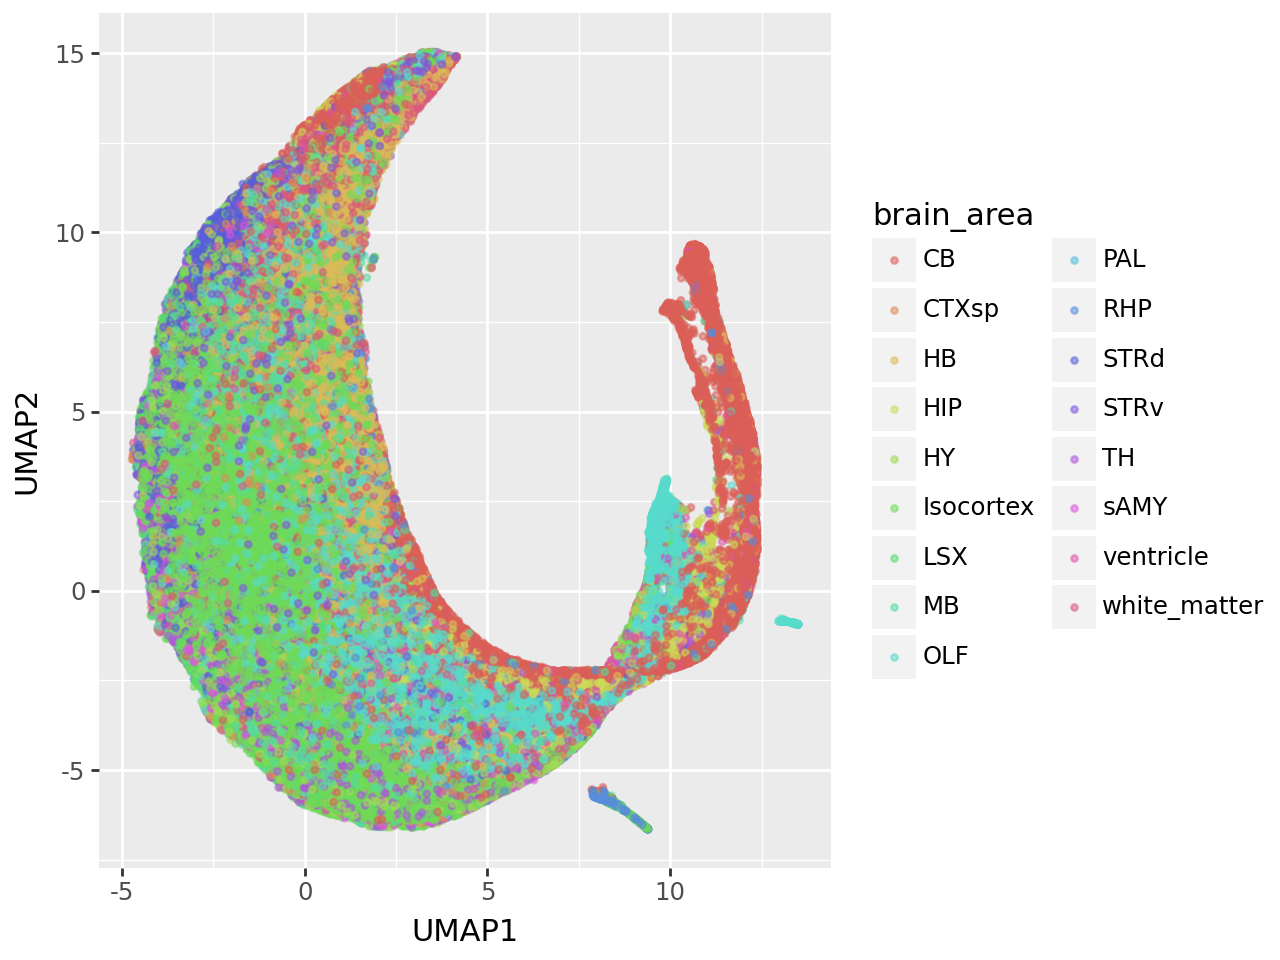

In [5]:
umap_results, plot_areas, plot_slices = umap_plot(embeddings, df_used)
plot_areas

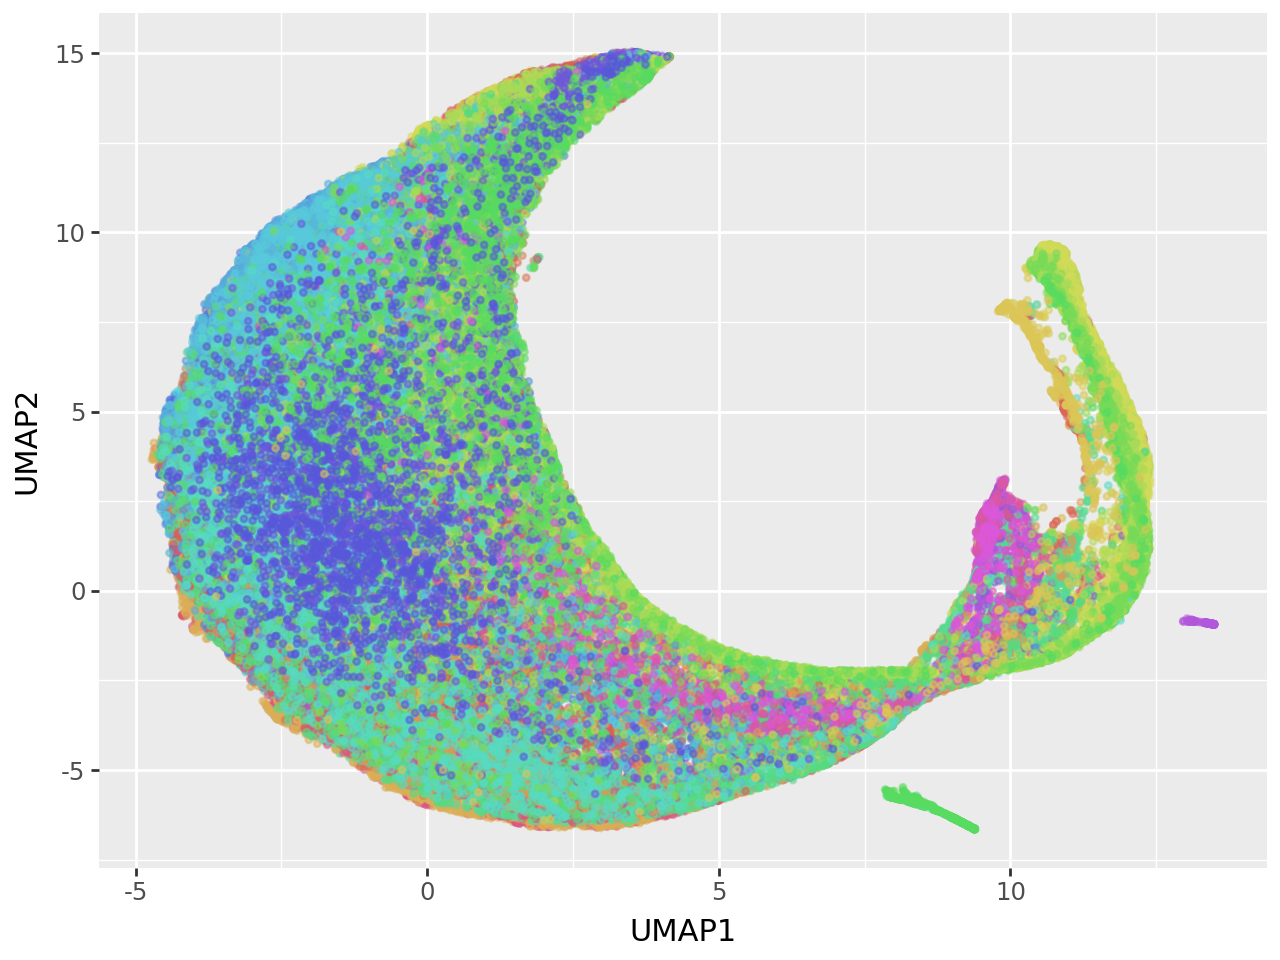

In [6]:
plot_slices + theme(legend_position='none')

## Use logistic regression

In [5]:
def log_reg(X, y, holdout_indices = []):
    
    X = np.delete(X, holdout_indices, axis= 0)
    y = np.delete(y, holdout_indices, axis= 0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=500)
    )
    clf.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = clf.predict(X_test)
    return(clf, y_test, y_pred)

def holdout_performance(clf, X, y, holdout_indices):
    X = X[holdout_indices]
    y = np.array(y)[holdout_indices]
    y_pred = clf.predict(X)

    return(accuracy_score(y, y_pred))

# Use extra holdout 100960408
holdout_indices = np.array(df_used.index[df_used["slice"] == "100960408"])

In [ ]:
clf, y_test, y_pred = log_reg(embeddings, df_used["brain_area"], holdout_indices)
print(classification_report(y_test, y_pred))

In [7]:
holdout_performance(clf, embeddings, df_used["brain_area"], holdout_indices)

0.5

## Look at variances across both dims

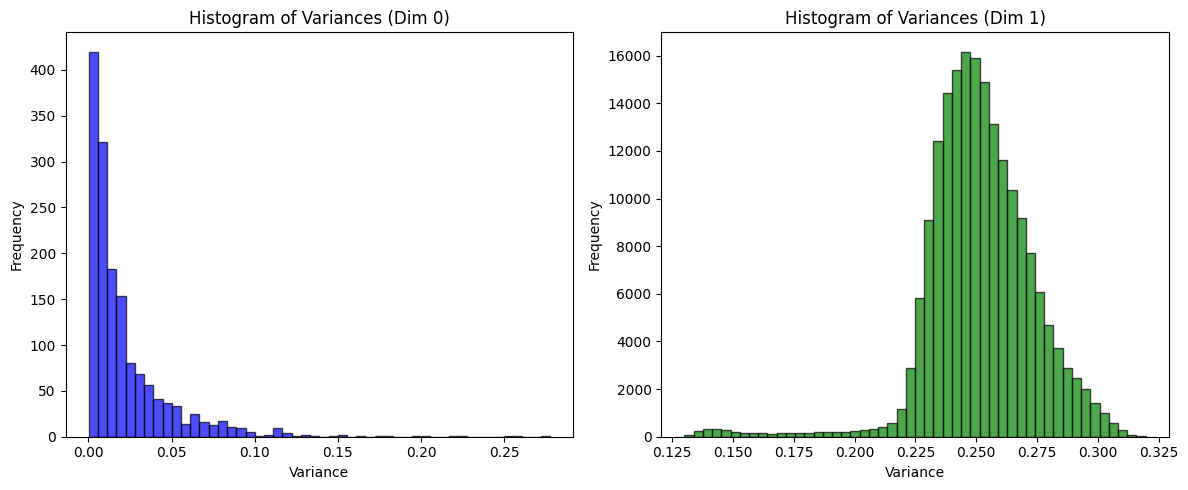

In [8]:
def variances_plot(embeddings, bins = 50):
    variances_dim0 = np.var(embeddings, axis=0)  # Variances across dim 0
    variances_dim1 = np.var(embeddings, axis=1)  # Variances across dim 1
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot variance histogram for dimension 0
    axes[0].hist(variances_dim0, bins=bins, color="blue", edgecolor="black", alpha=0.7)
    axes[0].set_xlabel("Variance")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Histogram of Variances (Dim 0)")
    
    # Plot variance histogram for dimension 1
    axes[1].hist(variances_dim1, bins=bins, color="green", edgecolor="black", alpha=0.7)
    axes[1].set_xlabel("Variance")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Histogram of Variances (Dim 1)")
    
    # Show plot
    plt.tight_layout()
    plt.show()
variances_plot(embeddings)

In [40]:
np.array(df_used["brain_area"])[holdout_indices].shape

(814,)

## Train a location regressor

In [7]:
def location_reg(X, df, holdout_indices = [], alpha = 1.0):

    y = df.loc[:, ["x", "y", "z"]].to_numpy()
    stratifier = df["brain_area"].to_numpy()
    
    X = np.delete(X, holdout_indices, axis= 0)
    y = np.delete(y, holdout_indices, axis= 0)
    stratifier = np.delete(stratifier, holdout_indices, axis= 0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=stratifier, random_state=42)
    
    reg = make_pipeline(
        StandardScaler(),
        Ridge(max_iter = 1500, alpha = alpha)
    )
    
    reg.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = reg.predict(X_test)
    return(reg, y_test, y_pred)

def reg_holdout(reg, X, df, holdout_indices):
    X = X[holdout_indices]
    y = np.array(df.loc[:, ["x", "y", "z"]])[holdout_indices]
    y_pred = reg.predict(X)

    return(r2_score(y, y_pred))

In [22]:
reg, reg_test, reg_pred = location_reg(embeddings, df_used, holdout_indices)
print(r2_score(reg_test, reg_pred))

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.1056e-09): result may not be accurate.


0.33823231378557095


In [27]:
reg_holdout(reg, embeddings, df_used, holdout_indices)

-36366.008847503435

# Repeat for larger patch size
## patch size 768

In [9]:
input_folder = "/p/project1/hai_fzj_bda/koenig8/histo/embeddings_768"

embeddings_768, df_768 = load_data(input_folder)
embeddings_768.shape, df_768.shape

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


((190659, 1536), (190659, 19))

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


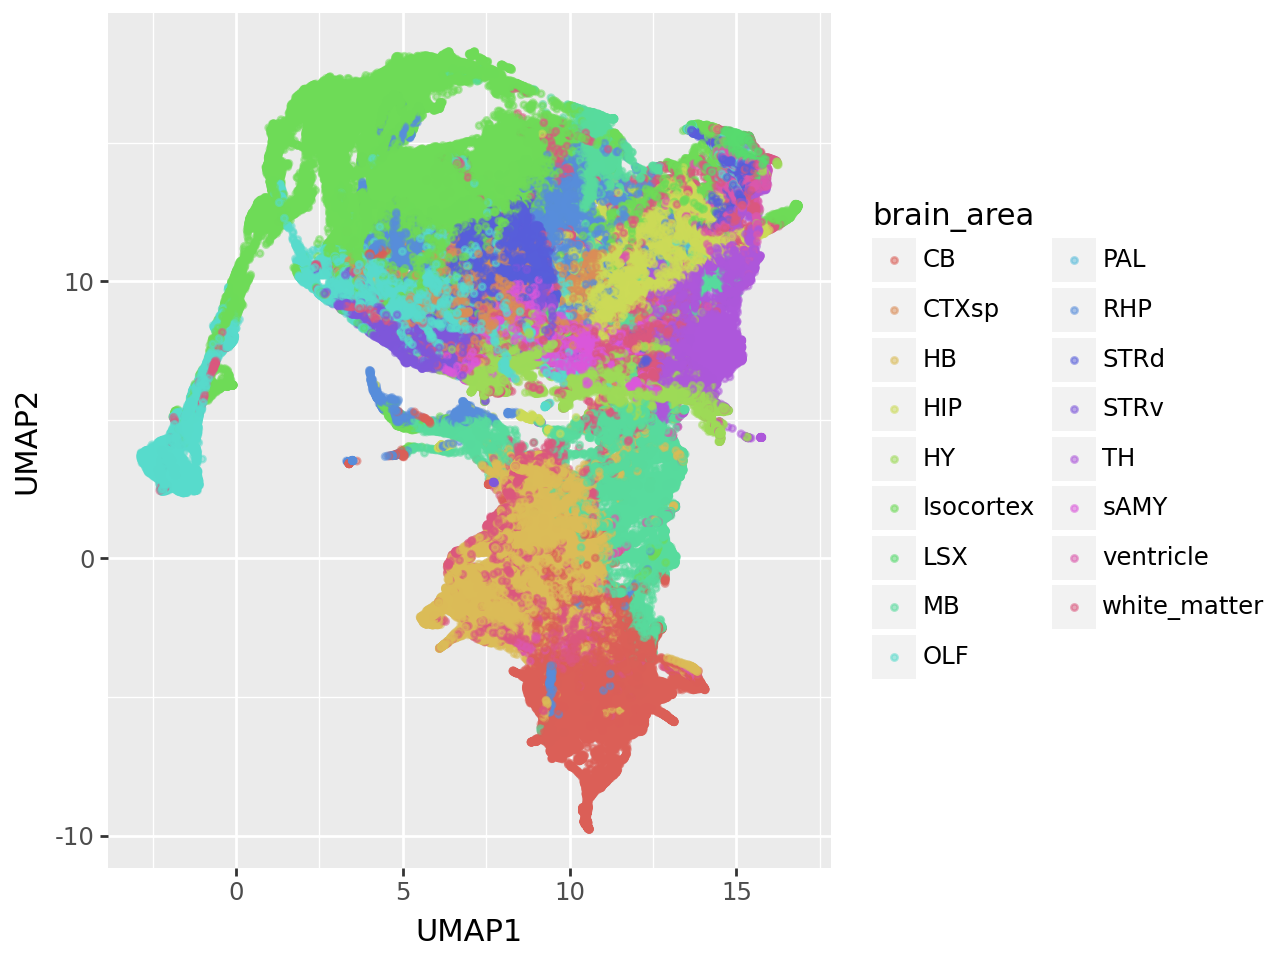

In [29]:
umap_results, plot_areas, plot_slices = umap_plot(embeddings_768, df_768)
plot_areas

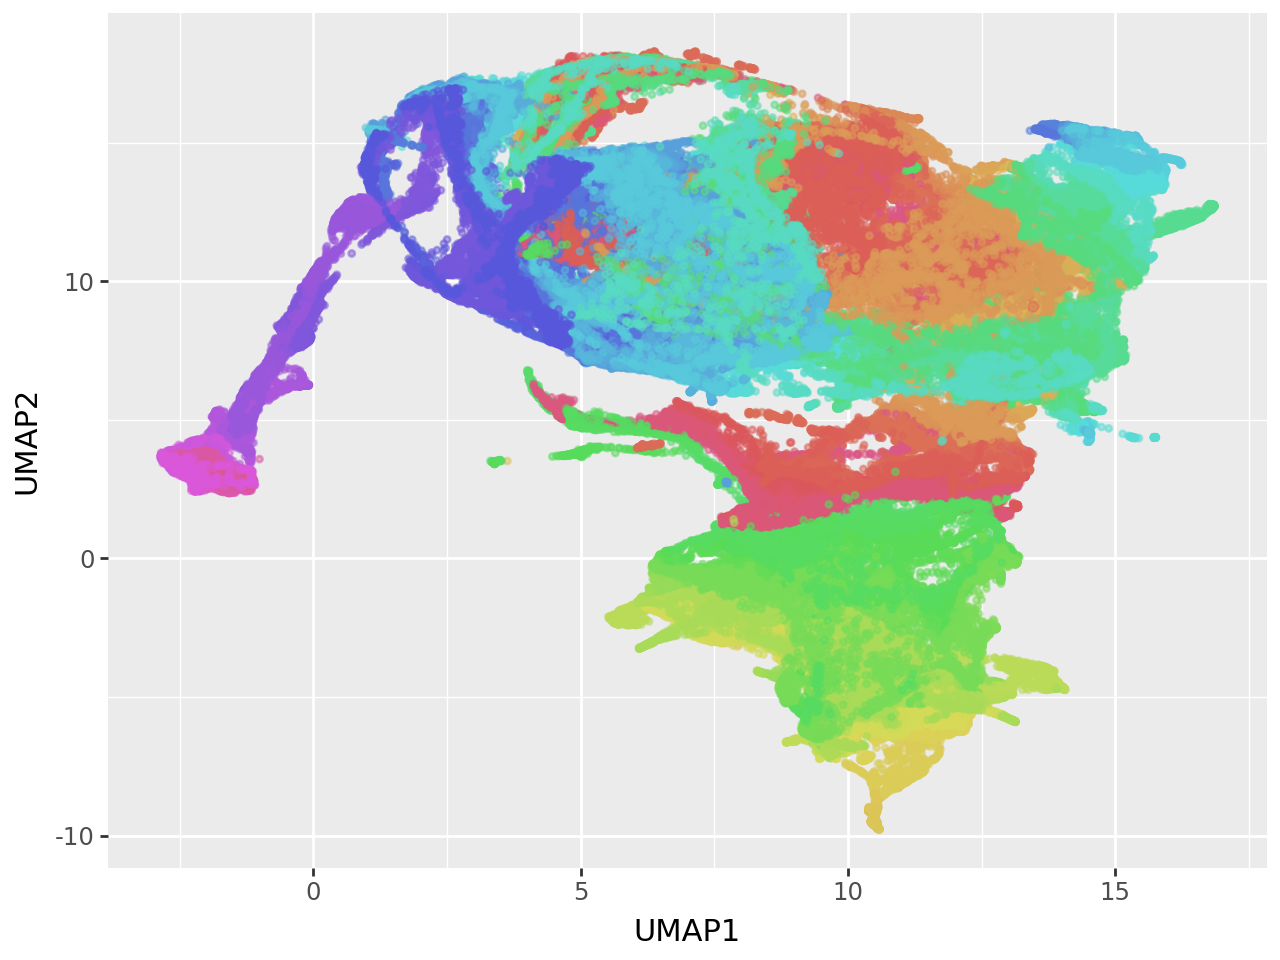

In [30]:
plot_slices + theme(legend_position='none')

In [10]:
holdout_indices = np.array(df_768.index[df_768["slice"] == "100960408"])

logreg_768, logreg_768_test, logreg_768_pred = log_reg(embeddings_768, df_768["brain_area"], holdout_indices)
print(classification_report(logreg_768_test, logreg_768_pred))

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

          CB       0.94      0.94      0.94      3750
       CTXsp       0.59      0.79      0.68       782
          HB       0.90      0.85      0.87      3934
         HIP       0.85      0.87      0.86      1604
          HY       0.79      0.83      0.81      1560
   Isocortex       0.97      0.91      0.94      9874
         LSX       0.76      0.85      0.80       309
          MB       0.87      0.86      0.87      3184
         OLF       0.88      0.85      0.86      2946
         PAL       0.06      0.07      0.06        14
         RHP       0.81      0.86      0.83      1890
        STRd       0.88      0.90      0.89      1864
        STRv       0.78      0.82      0.80      1029
          TH       0.87      0.88      0.88      1833
        sAMY       0.55      0.69      0.61       536
   ventricle       0.49      0.68      0.57       610
white_matter       0.57      0.56      0.56      2250

    accuracy              

In [11]:
holdout_performance(logreg_768, embeddings_768, df_768["brain_area"], holdout_indices)

0.9115479115479116

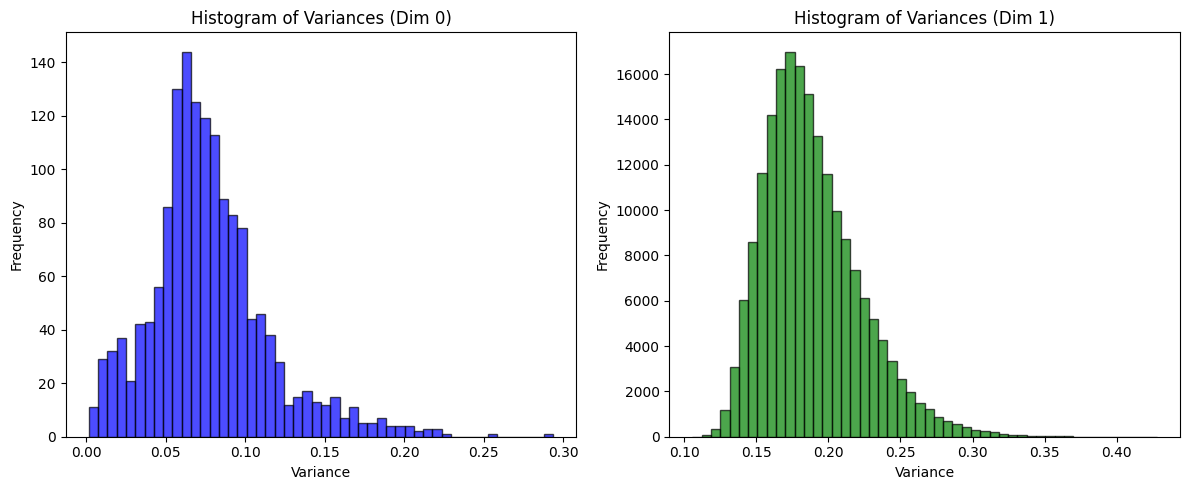

In [18]:
variances_plot(embeddings_768)

In [35]:
holdout_indices = np.array(df_768.index[df_768["slice"] == "100960408"])
reg, reg_test, reg_pred = location_reg(embeddings_768, df_768, holdout_indices, alpha = 500.0)
print(r2_score(reg_test, reg_pred))

0.7543849598227409


In [36]:
reg_holdout(reg, embeddings, df_used, holdout_indices)

-217521.8061274552

## Patch size scaled

In [9]:
input_folder = "/p/project1/hai_fzj_bda/koenig8/histo/embeddings_1024"

embeddings_1024, df_1024 = load_data(input_folder)
embeddings_1024.shape, df_1024.shape

((190659, 1536), (190659, 19))

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


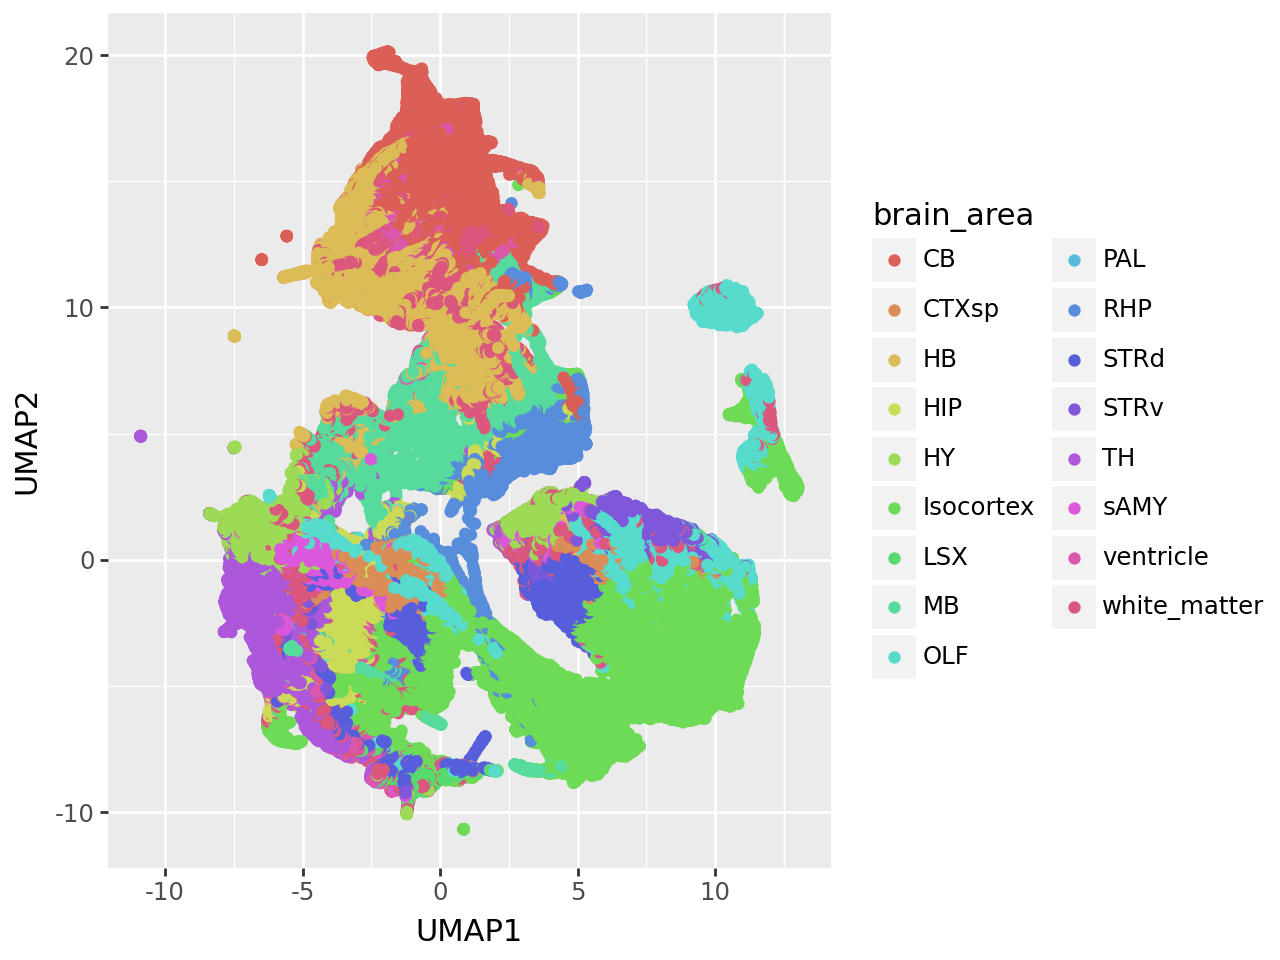

In [11]:
umap_results, plot_areas, plot_slices = umap_plot(embeddings_1024, df_1024)
plot_areas

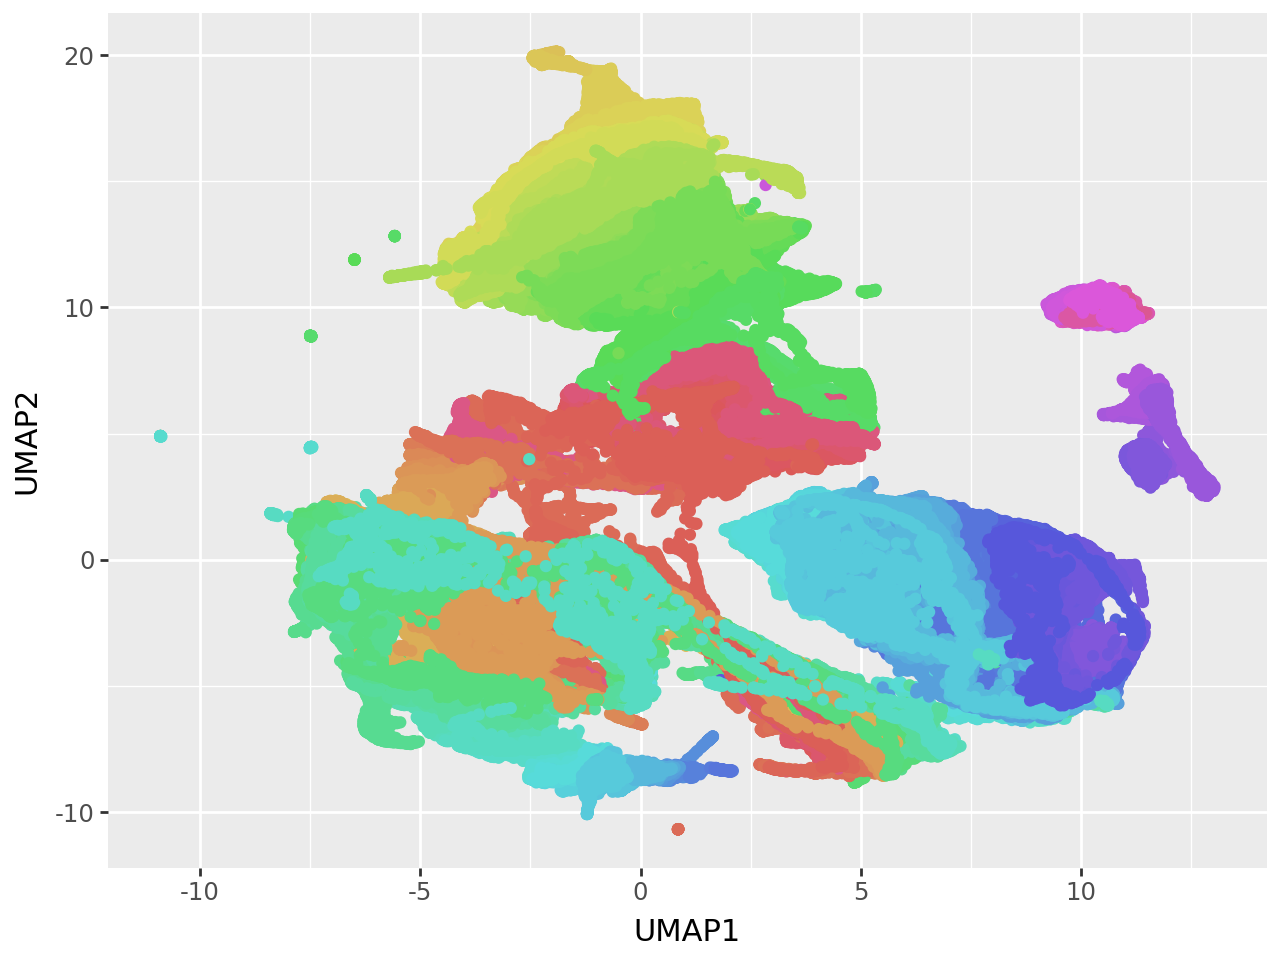

In [12]:
plot_slices + theme(legend_position='none')

In [13]:
holdout_indices = np.array(df_1024.index[df_1024["slice"] == "100960408"])

logreg_1024, logreg_1024_test, logreg_1024_pred = log_reg(embeddings_1024, df_1024["brain_area"], holdout_indices)
print(classification_report(logreg_1024_test, logreg_1024_pred))

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

          CB       0.94      0.94      0.94      3750
       CTXsp       0.63      0.81      0.71       782
          HB       0.90      0.84      0.87      3934
         HIP       0.86      0.89      0.87      1604
          HY       0.80      0.82      0.81      1560
   Isocortex       0.98      0.92      0.94      9874
         LSX       0.76      0.83      0.79       309
          MB       0.89      0.88      0.88      3184
         OLF       0.88      0.87      0.87      2946
         PAL       0.06      0.07      0.06        14
         RHP       0.83      0.89      0.86      1890
        STRd       0.87      0.91      0.89      1864
        STRv       0.77      0.80      0.78      1029
          TH       0.89      0.91      0.90      1833
        sAMY       0.60      0.73      0.66       536
   ventricle       0.49      0.69      0.57       610
white_matter       0.55      0.55      0.55      2250

    accuracy              

In [14]:
holdout_performance(logreg_1024, embeddings_1024, df_1024["brain_area"], holdout_indices)

0.902948402948403

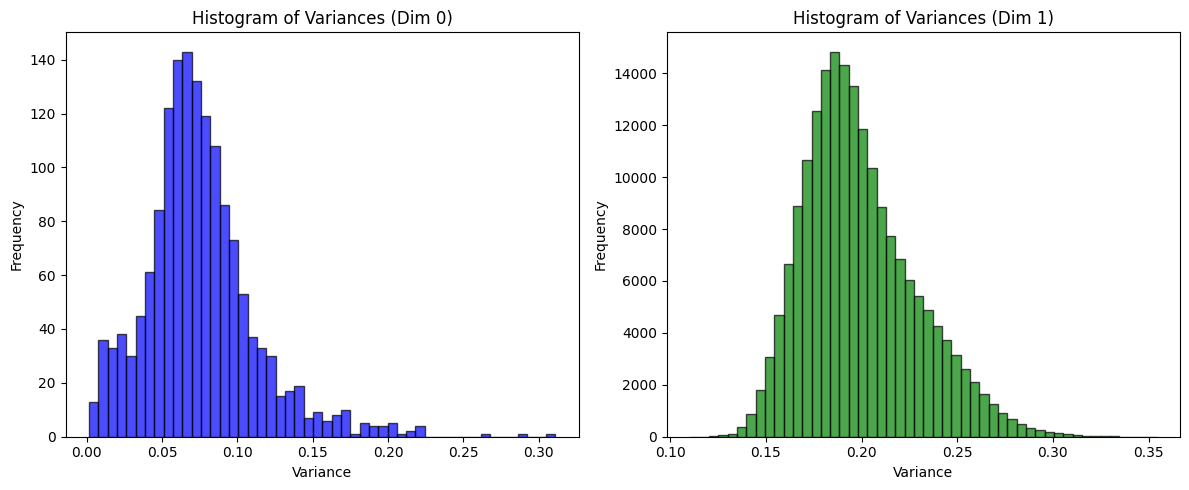

In [19]:
variances_plot(embeddings_1024)

# Look at performance on normalized slices

In [6]:
input_folder = "/p/project1/hai_fzj_bda/koenig8/histo/embeddings_scaled_768"

embeddings_scaled, df_scaled = load_data(input_folder)
embeddings_scaled.shape, df_scaled.shape

((190659, 1536), (190659, 19))

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


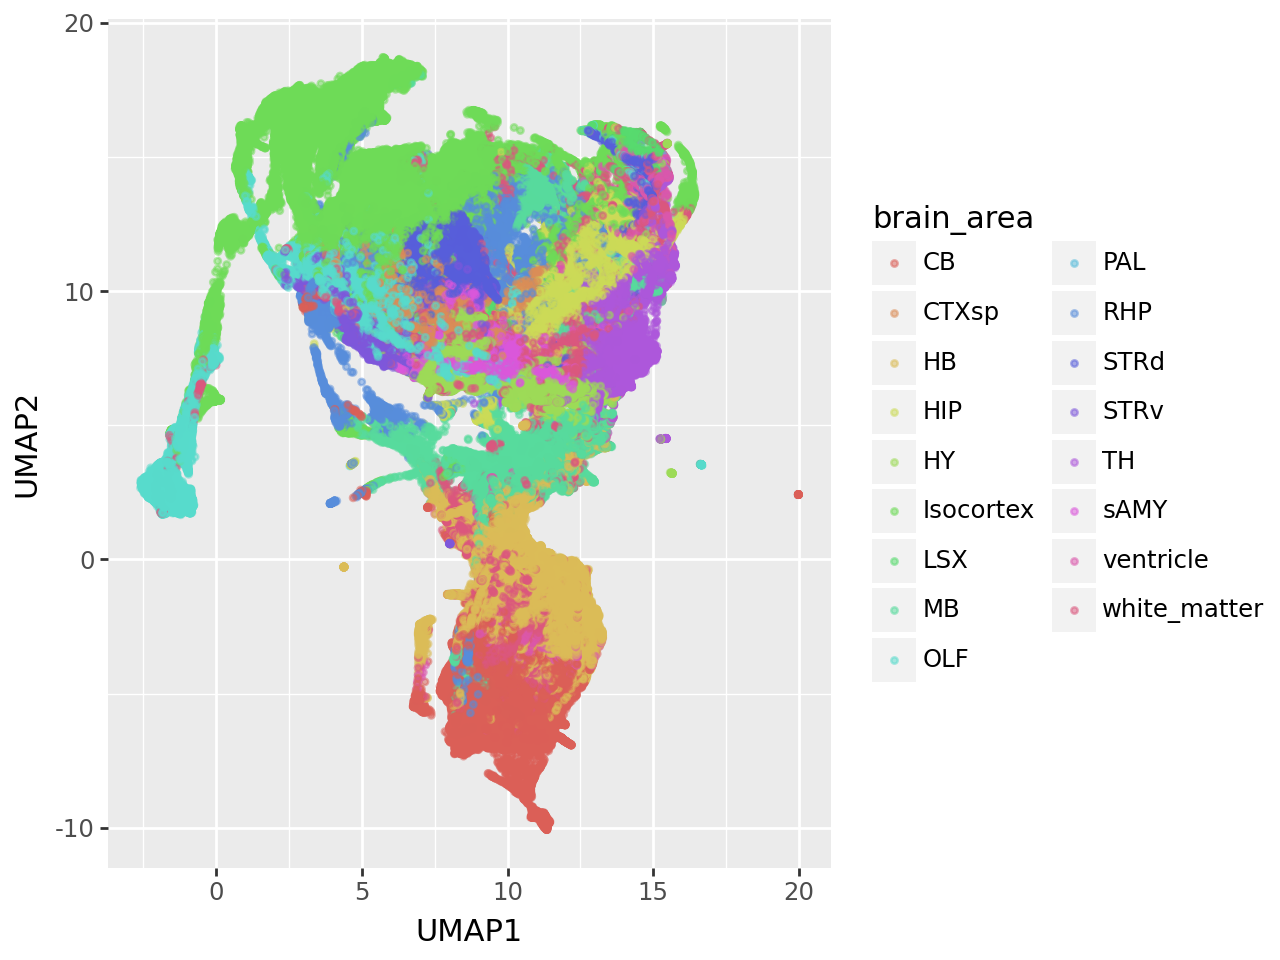

In [10]:
umap_results, plot_areas, plot_slices = umap_plot(embeddings_scaled, df_scaled)
plot_areas

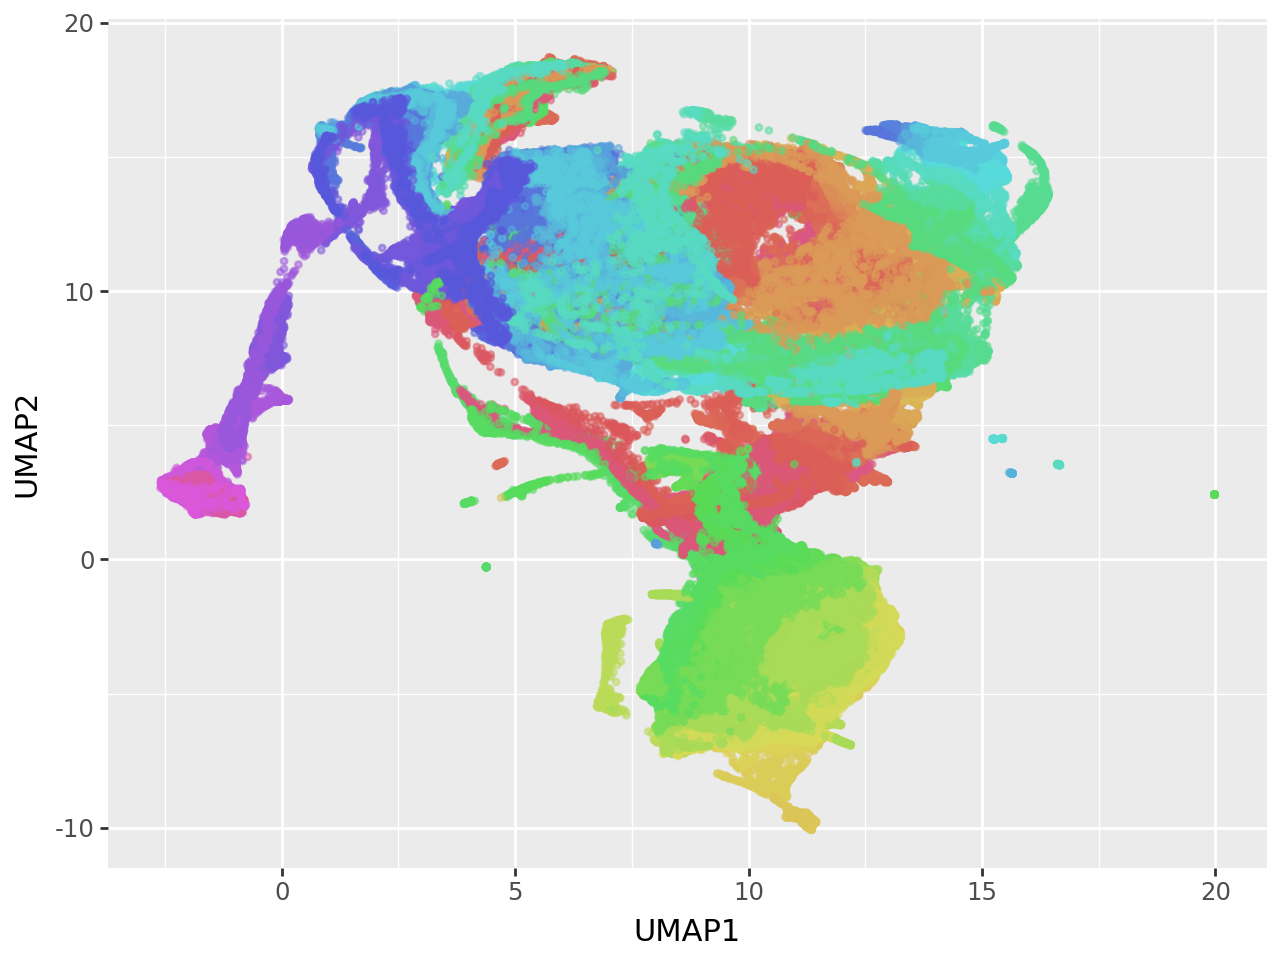

In [11]:
plot_slices + theme(legend_position='none')

In [15]:
holdout_indices = np.array(df_scaled.index[df_scaled["slice"] == "100960408"])

logreg_scaled, logreg_scaled_test, logreg_scaled_pred = log_reg(embeddings_scaled, df_scaled["brain_area"], holdout_indices)
print(classification_report(logreg_scaled_test, logreg_scaled_pred))

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/uni/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

          CB       0.94      0.94      0.94      3750
       CTXsp       0.59      0.79      0.68       782
          HB       0.89      0.84      0.86      3934
         HIP       0.85      0.87      0.86      1604
          HY       0.79      0.82      0.80      1560
   Isocortex       0.97      0.90      0.94      9874
         LSX       0.75      0.85      0.80       309
          MB       0.87      0.86      0.87      3184
         OLF       0.87      0.85      0.86      2946
         PAL       0.16      0.21      0.18        14
         RHP       0.80      0.86      0.83      1890
        STRd       0.87      0.90      0.89      1864
        STRv       0.77      0.82      0.80      1029
          TH       0.87      0.89      0.88      1833
        sAMY       0.56      0.69      0.62       536
   ventricle       0.48      0.68      0.56       610
white_matter       0.56      0.55      0.55      2250

    accuracy              

In [16]:
holdout_performance(logreg_scaled, embeddings_scaled, df_scaled["brain_area"], holdout_indices)

0.9004914004914005